## Run likelihood scan for $A_s$, using full_theory

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import fit_linP

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data (this is the simulation for our default model)
test_sim_num=30
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,basedir=basedir,skewers_label=skewers_label)

### Setup archive of P1D measurements from simulations and train the emulator

In [4]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


### Setup likelihood object, with full theory, and using the truth as fiducial model

In [6]:
free_params=["As"]
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_parameters=free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [7]:
# print default cosmology
for par in like.theory.camb_model_fid.get_likelihood_parameters():
    print(par.info_str(),', in cube =',par.value_in_cube())

ombh2 = 0.022000140100000003 , in cube = 0.5000233500000004
omch2 = 0.11999994800000002 , in cube = 0.39999896000000046
As = 2.006055e-09 , in cube = 0.030274999999999712
ns = 0.967565 , in cube = 0.5855000000000012
H0 = 67.0 , in cube = 0.2857142857142857
mnu = 0.0 , in cube = 0.0


In [8]:
# identify parameter we are interested in
par=like.get_parameter_by_name('As')
true_As=par.value

In [9]:
# setup grid of As values to evaluate
NAs=21
Asmin=1.9e-9
Asmax=2.2e-9
As=np.linspace(Asmin,Asmax,NAs)
log_like=np.empty(NAs)

In [10]:
for i in range(NAs):
    # I hate python (you should not be allowed to do this)
    par.value=As[i]
    log_like[i]=like.get_log_like(values=[par.value_in_cube()],ignore_log_det_cov=True)
    print(i,As[i],log_like[i])

0 1.9e-09 -24.21944626513207
1 1.915e-09 -20.23517434475929
2 1.93e-09 -16.55174186255176
3 1.9450000000000002e-09 -13.208506773438192
4 1.96e-09 -10.240439137341964
5 1.975e-09 -7.676866272050904
6 1.99e-09 -5.540381548652238
7 2.005e-09 -3.845998684981218
8 2.02e-09 -2.600621732483109
9 2.035e-09 -1.8028813888275048
10 2.05e-09 -1.4433588355747895
11 2.065e-09 -1.505186213070686
12 2.08e-09 -1.964978244361225
13 2.095e-09 -2.7940213855260114
14 2.11e-09 -3.9596268466327977
15 2.125e-09 -5.426545892276102
16 2.14e-09 -7.158349732260946
17 2.155e-09 -9.118691936710947
18 2.1699999999999997e-09 -11.272391489256037
19 2.185e-09 -13.586300874891043
20 2.2e-09 -16.0299463205799


Text(0, 0.5, 'Log Likelihood')

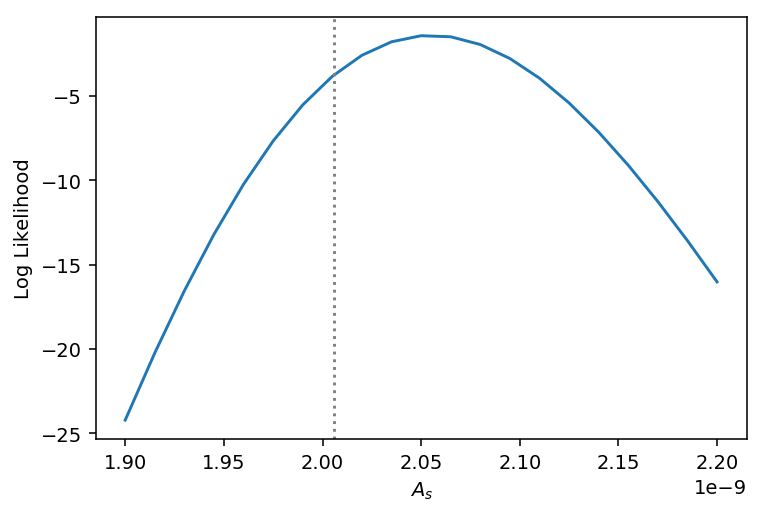

In [11]:
plt.plot(As,log_like)
plt.axvline(x=true_As,ls=':',color='gray')
plt.xlabel(r'$A_s$')
plt.ylabel(r'Log Likelihood')

These results are not horrible, but not great either... 
Given that there is no noise, and no approximations, the 2% bias in $A_s$ is probably caused by the emulator.